# ECON 323 Project

## Predicting House Price in Melbourne City via Machine Learning Model
Chenyue Qian

### 1. Introduction

#### 1.1 Background
Housing Market is always a hotly-discussed topic among individuals since many people, as investors, are trying to make profits through buying and selling houses. For Melbourne, being a city that attracts a lot of new immigrants, it has high demands for houses, which conseqenutly leads to a very hot and fluctuate housing market (Zhou, 2019). Therefore, using models to predict house price is really meaningful since it not only provides sellers with benchmark of selling price of a house but also help the customer to find a right price to purchase a house.


#### 1.2 Research Question
What would be a house's selling price in Melbourne based on its characteristics?

#### 1.3 General Strategy
In order to answer this question, I would try to use three different methods (Linear Regression, Random Forest and KNN regression). Then, I would compare all these three methods to see the best one and use that as our prediction model of the houses' selling prices in Melbourne.

#### 1.4 Dataset

The dataset was found from [Kaggle](https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv), which includes information regarding many traded houses in Melbourne during the recent years. These data were scraped by Tony Pino from the Domain, which is an Australian commercial real estate portal. Here is a summary of part of the data that could be useful in this project:


* **House Price**: House Price in Australian dollars 
* **Type** : House Types: h (houses, cottages, villas, semis, terraces), u (apartments, duplex), t (townhouses).
* **Rooms** : Number of rooms in the house
* **Distance** : Distance from CBD in kilometres 
* **Bedroom2** (Changed to **Bedroom** later) : Number of bathrooms in the house 
* **Bathroom** : Number of bathrooms in the house 
* **Car** : Number of car spots 
* **Lattitude**(Changed to **Latitude** later) / **Longtitude** (Changed to **Longitude** later): House's location on the map
* **Landsize** : the Land Size for the house in Meters
* **YearBuilt** : the year when the house was built

### 2.Exploratory Data Analysis

In this section, I would conduct some Exploratory Data Analysis (EDA) to learn more about the data I have, especially paying attention to the relation between those variables and the house price. The main tasks in this section are data cleaning and visualzation.

In [1]:
# load all the packages first
import googlemaps
import pandas as pd
import re 
import numpy as np
import folium
import branca
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import linear_model
import seaborn as sns
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
pd.options.mode.chained_assignment = None

/var/folders/jl/1khzkhj12y31c7l67b3d0hpw0000gn/T/ipykernel_72971/577558933.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# read data from my github repository
df = pd.read_csv("https://raw.githubusercontent.com/ScottCY/ECON323-Project/main/Melbourne_housing_FULL.csv") # load data
df.head()

Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt         CouncilArea Lattitude  Longtitude             Regionname  \
0        NaN  Yarra City Council  -37.8014    144.9958  Northern Metropolitan   
1        NaN  Yarra City Council  -37.7996    144.9984  Northern Metropolitan   
2     1900.0  Yarra City Council  -37.8079    144.9934  Northern Metropolitan   
3        NaN  Yarra City Council  -37.8114    145.0116  Northern Metropolitan   
4     1900.0  Yarra City Council  -37.8093    144.9944  Northern Metropolitan   

  Propertycount  
0        4019.0  
1        4019.0  
2        4019.0  
3        4019.0  
4        4019.0  

[5 rows x 21 columns]

#### 2.1 Data Cleaning

In [3]:
# change variable name to make it more readable
df["Bedroom"] = df["Bedroom2"]
df["Latitude"] = df["Lattitude"]
df["Longitude"] = df["Longtitude"]


In [4]:
# keep only useful variables for our project, 
df1 = df[['Rooms', 'Type', 'Price', 'Distance', 'Bedroom', 'Bathroom', 'Car',
       'Landsize', 'Latitude',
       'Longitude', 'YearBuilt']]


From the dataset, I can already see that some variables would be useless for the prediction, such as the Seller and Method. Hence, based on my personal judgement, I first select all the variables that might be helpful in prediction and create a new dataset.

In [5]:
# Check the shape of our data
df1.shape

(34857, 11)

From the first several rows, there are some data with NAs'; hence, it is important to remove those data in advance. Meanwhile, as we can see there are more than 30 thousands rows, removing those NA rows may not hurt our prediction too much. (I would still have a fairly large dataset for perform our traning) After this step, I would achieve a dataset that allows me to start doing data manipulation.

In [6]:
# Remove all the rows that contains NA values
df_new = df1.dropna()
print(df_new.shape)
df_new.head()

(10459, 11)


Rooms Type      Price  Distance  Bedroom  Bathroom  Car  Landsize  \
2       2    h  1035000.0       2.5      2.0       1.0  0.0     156.0   
4       3    h  1465000.0       2.5      3.0       2.0  0.0     134.0   
6       4    h  1600000.0       2.5      3.0       1.0  2.0     120.0   
11      3    h  1876000.0       2.5      4.0       2.0  0.0     245.0   
14      2    h  1636000.0       2.5      2.0       1.0  2.0     256.0   

    Latitude  Longitude  YearBuilt  
2   -37.8079   144.9934     1900.0  
4   -37.8093   144.9944     1900.0  
6   -37.8072   144.9941     2014.0  
11  -37.8024   144.9993     1910.0  
14  -37.8060   144.9954     1890.0

At this stage, the data looks better. But there are still two steps I need to do before creating the training and testing set. 
1. Dummy variables creation:  
As I have a categorical variable "Type", it is important to first create dummy variables. Noting that there are three types of houses: "h", "u", "t", we would need two dummy variables. The reason is that once we know the value for two of them, we would directly know the last one (lose one degree of freedom). Based on my personal choice, I choose to create the dummy variables for house types "h" and "u".
2. Data transformation:                       
By looking at the data I have above, I decide to build the model with the log of the **house price** instead of the orginal values. The reason is that the relationship between house prices and other possible predictors are not always linear. For example, considering the number of rooms, an increase of rooms from 2 to 3 would usually have much bigger effect on house price compared with an increase of number of rooms from 6 to 7. In this case, taking the log of the price would be helpful to perform the linear regression.

In [7]:
# Create the dummy variables
df_new["h"] = 0
df_new["h"].loc[df_new["Type"] == "h"] = 1

df_new["u"] = 0
df_new["u"].loc[df_new["Type"] == "u"] = 1

In [8]:
# Data transformation
df_new["Log_Price"] = np.log(df_new["Price"])

Now, after getting the tidy data, I could determine my training dataset and testing dataset. 

I’ve split the data into 70% training and 30% testing in order to ensure I have enough data to evaluate my model. Meanwhile, as I have a catagorical variable (the house type), it is a good practice to ensure the training dataset and testing dataset have same proportion for each of them. This step here would ensure that there are enough data for each house type. 

In [9]:
# Seperate the data according to the Type and get the training and testing data
h = df_new.loc[df_new["Type"] == "h"]
u = df_new.loc[df_new["Type"] == "u"]
t = df_new.loc[df_new["Type"] == "t"]
h_train, h_test = train_test_split(h, test_size=0.3, random_state=10)
u_train, u_test = train_test_split(u, test_size=0.3, random_state=10)
t_train, t_test = train_test_split(t, test_size=0.3, random_state=10)

train = pd.concat([h_train, u_train, t_train])
test = pd.concat([h_test, u_test, t_test])

#### 2.3 Visualization

In this section, I would first try to visualization our data. This could give me a prior idea about some of the suitable predictors in the model. I would do this in three seperate parts, with each part focusing on:
1. Categorical variable
2. Quantitative Variable
3. Spatial Variable


##### 2.3.1 Categorical Variable

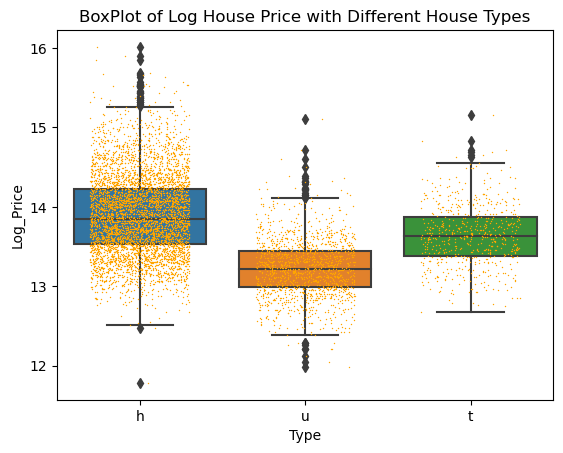

In [10]:
# Visualize the relationship between type and house price

sns.boxplot(y="Log_Price", x="Type", data = train)
sns.stripplot(x='Type', y='Log_Price', data=train, color="orange", jitter=0.3, size=1)

plt.ylabel("Log_Price")
plt.title("BoxPlot of Log House Price with Different House Types")
plt.show()

By looking at this boxplot, we can see that type of the house could be a good choice of predictor. This is because the three types of houses have log house prices that squeeze in different places: house that is type "h" generally has a higher price than type "t" and type "u". Meanwhile, one thing that is worth noting is that more than 75 percent of the houses that are type "h" have price higher than 75 percent of houses that are type "u". 

Also, based on this plot and my personal experience, I believe the type of the house would have a larger influence on the log price compared with other variables. Hence, in some of the following visualizations, I would try to create plots only for a type at a time. In this case, we can better see the influence of other variables to the log price since this makes sure that their effects would not be hided by the house type.

##### 2.3.2 Quantitative Variable

In [11]:
train[['Log_Price','Rooms', 'Type', 'Distance', 'Bedroom', 'Bathroom', 'Car',
       'Landsize', 'YearBuilt']].describe()

Log_Price        Rooms     Distance      Bedroom     Bathroom  \
count  7319.000000  7319.000000  7319.000000  7319.000000  7319.000000   
mean     13.740655     3.063260    11.082880     3.047684     1.632327   
std       0.537360     0.977033     6.721878     0.977078     0.722268   
min      11.782953     1.000000     0.000000     0.000000     1.000000   
25%      13.353475     2.000000     6.400000     2.000000     1.000000   
50%      13.688813     3.000000    10.200000     3.000000     2.000000   
75%      14.096923     4.000000    13.900000     4.000000     2.000000   
max      16.012735    10.000000    47.400000    10.000000     9.000000   

               Car      Landsize    YearBuilt  
count  7319.000000   7319.000000  7319.000000  
mean      1.687252    526.306873  1966.359339  
std       0.975031   1075.258141    35.770344  
min       0.000000      0.000000  1830.000000  
25%       1.000000    201.000000  1950.000000  
50%       2.000000    464.000000  1970.000000  
75%       2.000000    652.000000  2000.000000  
max      10.000000  42800.000000  2019.000000

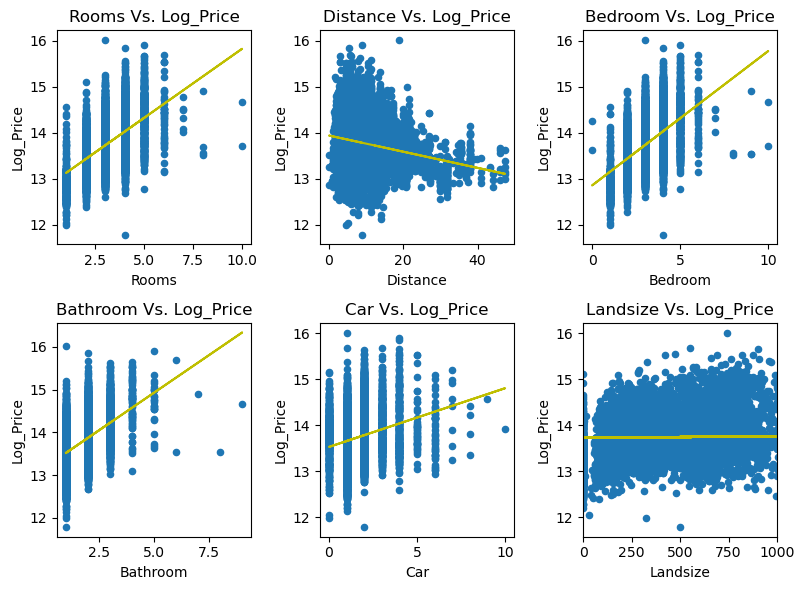

In [12]:
## plot graphs.

fig, axes = plt.subplots(2,3, figsize=(8,6))
colname = ['Rooms', 'Distance', 'Bedroom', 'Bathroom', 'Car', 'Landsize']

for i in range(len(colname)):
    if i < 3:
        train.plot.scatter(colname[i], "Log_Price", ax=axes[0,i])
        axes[0,i].set_title(f"{colname[i]} Vs. Log_Price")
        m, b = np.polyfit(train[colname[i]], train["Log_Price"], 1)
        axes[0,i].plot(train[colname[i]], m*train[colname[i]]+b, 'y')
    else:
        train.plot.scatter(colname[i], "Log_Price", ax=axes[1,i-3])
        axes[1,i-3].set_title(f"{colname[i]} Vs. Log_Price")
        m, b = np.polyfit(train[colname[i]], train["Log_Price"], 1)
        axes[1,i-3].plot(train[colname[i]], m*train[colname[i]]+b, 'y')


fig.tight_layout()
axes[1,2].set_xlim(0,1000)
plt.show()

Firstly, I look at these six variables('Rooms', 'Distance', 'Bedroom', 'Bathroom', 'Car', 'Landsize'). From these scatter plot, I can see that 'Rooms', 'Distance', 'Bedroom', 'Bathroom' might be good predictors for the models. For Landsize, it is clear that there is no pattern.

<Axes: >

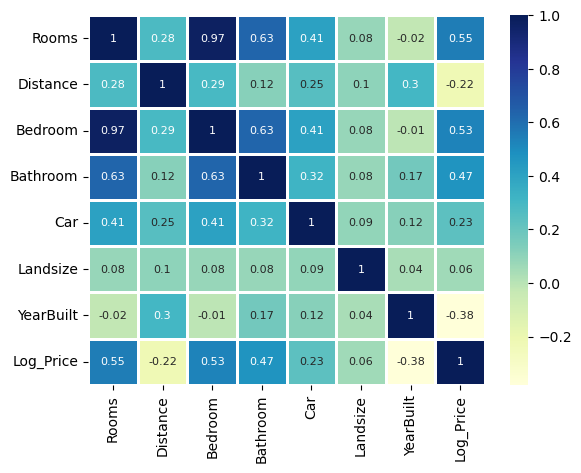

In [13]:
cormat = round(train[['Rooms', 'Distance', 'Bedroom', 'Bathroom', 'Car', 'Landsize', 'YearBuilt','Log_Price']].corr(), 2)
sns.heatmap(cormat,cmap = 'YlGnBu', linewidth = 1, annot = True, annot_kws = {'size':8})

By checking this correlation matrix, we can see some linear relationship between log price and these variables. For Landsize, the correlation matrix shows that the linear relationship is only around 0.03, indicating that this is not a good predictor. Also, the linear relationship between Car and Price is not strong, with a correlation of only 0.22. Hence, from here, three variables (**Rooms, Bedroom, Bathroom**), have moderate linear relationship with the log house price. 

Now, I would like to look at the two variables, Car and YearBuilt, more carefully.

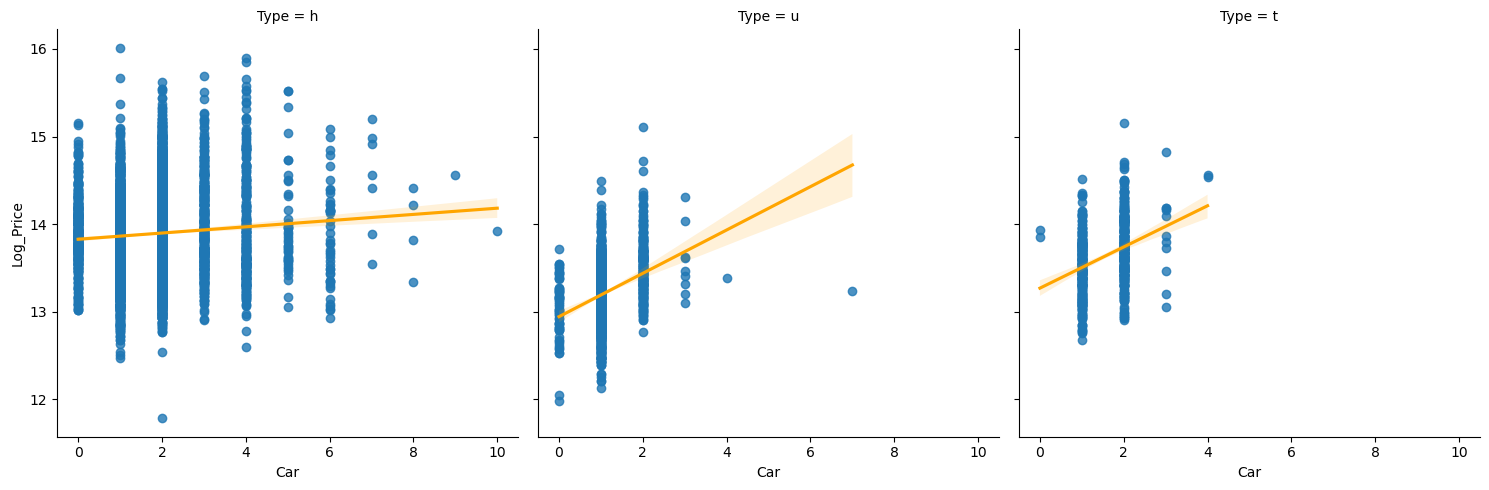

In [14]:
# Plot about Car and Log Price
sns.lmplot(data=train, x= "Car", y="Log_Price", col= "Type", line_kws={'color': 'orange'})

The plot shows that the number of car would be more useful in prediction regarding type u and type t, but not in type h.

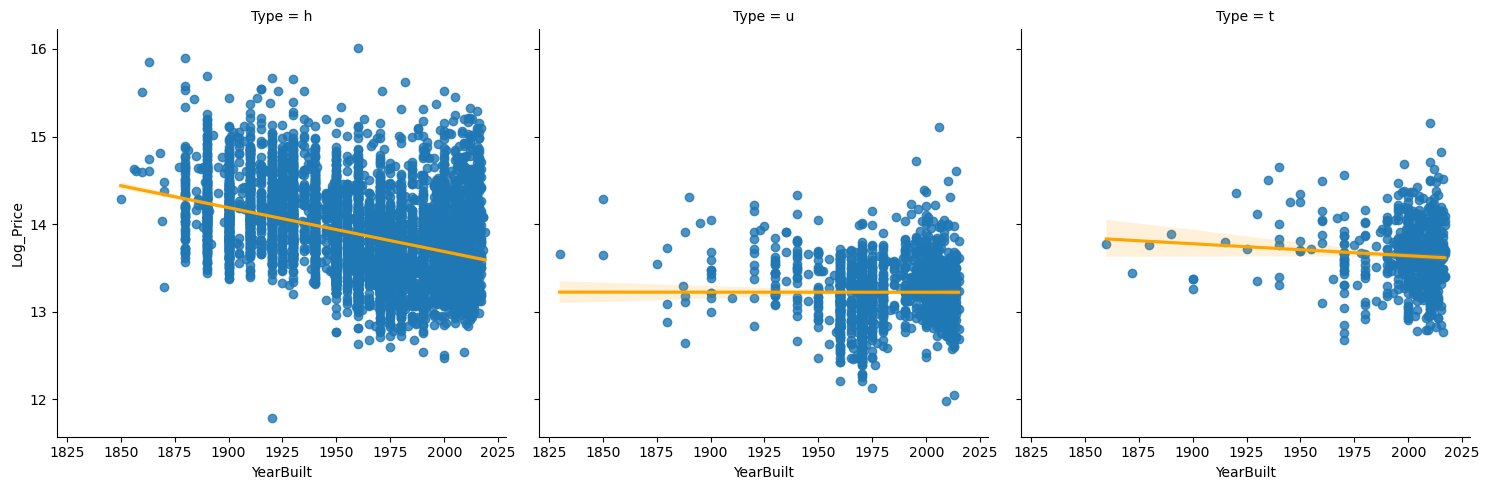

In [15]:
# Plot about YearBuilt and Log Price
sns.lmplot(data=train, x= "YearBuilt", y="Log_Price", col= "Type", line_kws={'color': 'orange'})

The plots shows that the year when the house is built may not be a good predictor since the price vary a lot for a single year. Also, it is interesting that most older houses with type h have slightly higher price, which is not what I expected.

##### 2.3.3 Spatial Variable

The longitude and latitude variables could be useful to perform the KNN regression. Hence, I would look at the these two variables here to see whether the location would have an significant influence to the log price. But one thing to note is that I seperate the data into three pieces since the house type usually would have a big influence on the house price.

In [38]:
# All the materials in these following box is used to create maps
# key= ## Value omit, get your own api key from google maps

gmaps = googlemaps.Client(key=key) 

m_h = folium.Map(width=500,height=500,location=[-37.8136, 144.963], zoom_start = 10, tiles = "CartoDB positron")
m_u = folium.Map(width=500,height=500,location=[-37.8136, 144.963], zoom_start = 10, tiles = "CartoDB positron")
m_t = folium.Map(width=500,height=500,location=[-37.8136, 144.963], zoom_start = 10, tiles = "CartoDB positron")


In [17]:
summary_h = (h_train["Log_Price"]).describe().iloc[3:]

fname = 'test_colorbar.html'
#### index was for color set according to the 5-number summary of the price
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'orange', 'red'],
                             index=summary_h, vmin=summary_h[0], vmax=summary_h[-1],
                             caption='Log_Price')
for i in range(len(h_train["Price"])):
    folium.CircleMarker([h_train.iloc[i]['Latitude'], h_train.iloc[i]['Longitude']],
                        radius=1,
                        fill= True,
                        color=colormap(h_train.iloc[i]['Log_Price']),
                        opacity=0.5
                       ).add_to(m_h)

m_h.add_child(colormap)
                        

<font color='grey'> Map for All Selling Houses with Type h (Houses) <font>

In [18]:
# Create map for House type u
summary_u = (u_train["Log_Price"]).describe().iloc[3:]

fname = 'test_colorbar.html'
#### index for color was set according to the 5-number summary of the price
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'orange', 'red'],
                             index=summary_u, vmin=summary_u[0], vmax=summary_u[-1],
                             caption='Log_Price')
for i in range(len(u_train["Price"])):
    folium.CircleMarker([u_train.iloc[i]['Latitude'], u_train.iloc[i]['Longitude']],
                        radius=1,
                        fill= True,
                        color=colormap(u_train.iloc[i]['Log_Price']),
                        opacity=0.5
                       ).add_to(m_u)

m_u.add_child(colormap)

<font color='grey'> Map for All Selling Houses with Type u (Apartments) <font>

In [19]:
summary_t = (t_train["Log_Price"]).describe().iloc[3:]

fname = 'test_colorbar.html'
#### index for color was set according to the 5-number summary of the price
colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan','orange', 'red'],
                             index=summary_t, vmin=summary_t[0], vmax=summary_t[-1],
                             caption='Log Price')
for i in range(len(t_train["Price"])):
    folium.CircleMarker([t_train.iloc[i]['Latitude'], t_train.iloc[i]['Longitude']],
                        radius=1,
                        fill= True,
                        color=colormap(t_train.iloc[i]['Log_Price']),
                        opacity=0.5
                       ).add_to(m_t)

m_t.add_child(colormap)

<font color='grey'> Map for All Selling Houses with Type t (Townhouses) <font>

By looking at these three maps, we can see that for the types h and t, the prices of the houses are well-seperated by the geometric locations. For the houses with type u, it is not seperated very well. Hence, based on this analysis, I predicted that the KNN regression with geometric location as the predictors have a high chance to do a good prediction with house types h and t. 

(**NOTE** These three plots should be interactive (with the code above), but it seems that the plot cannot be shown when I open my notebook in other people's jupyter, so I include the photos here.)

### 3. Modelling

Now, I would start doing models. I would create three models: linear regression, random forest and KNN regression.
Note that all three models would predicting log price, and all the comparsion I am doing in this section would be with **LogPrice**.

#### 3.1 Linear Regression

In this subsection, I would create linear regression model. Based on the Exploratory Data Analysis and my own statistical intuition, I choose the variables ('Rooms', 'Distance', 'Bedroom', 'Bathroom', 'h', 'u') to start with.

In [20]:
X_train = train[['Rooms', 'Distance', 'Bedroom', "Car", 'Bathroom', 'h', 'u']]
y_train = train['Log_Price']

In [21]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1298.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        16:18:42   Log-Likelihood:                -2883.9
No. Observations:                7319   AIC:                             5784.
Df Residuals:                    7311   BIC:                             5839.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1835      0.022    607.784      0.0

I choose to remove the Bedroom as the p-value is really large here. The reason might be that it is highly correlated with Rooms, so maybe use one of them is good enough.

In [22]:
lm = linear_model.LinearRegression()

x_train = X_train[['Rooms', 'Distance', 'Bathroom', 'h', 'u']]

lm.fit(x_train, y_train)
x_test = test[['Rooms', 'Distance', 'Bathroom', 'h', 'u']]
y_test = test["Log_Price"]

In [23]:
predict_price_lm = lm.predict(x_test)
rmse_lm = np.sqrt(mean_squared_error(predict_price_lm,y_test))
rmse_lm

0.35756046730650404

Here, I perform the linear regression based on the training data I have. Then, I test my model with my testing dataset and get the Root Mean Square Error to be 0.35756.

True_Value  Predicted_Value
True_Value         1.000000         0.745339
Predicted_Value    0.745339         1.000000

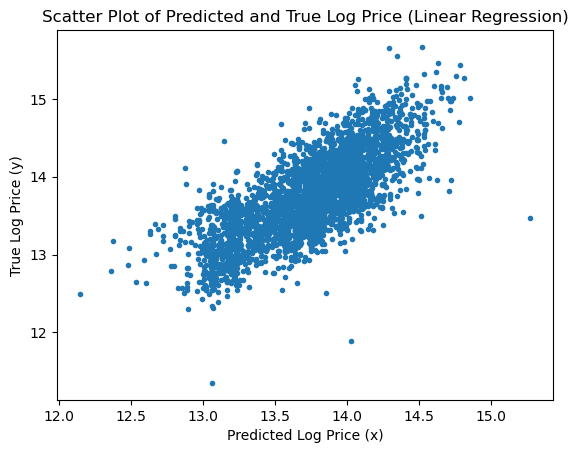

In [24]:
plt.plot(predict_price_lm, y_test, '.')
plt.xlabel("Predicted Log Price (x)")
plt.ylabel("True Log Price (y)")
plt.title("Scatter Plot of Predicted and True Log Price (Linear Regression)")
a = pd.DataFrame(predict_price_lm, y_test).reset_index()
a = a.rename(columns={"Log_Price": "True_Value", 0: "Predicted_Value"})
a.corr()

This scatter plot shows that the predicted log price and true log price are scattered around $y = x$, which is when the predicted log price equal to the true log price. Also, the correlation between them is around 0.745, which is fairly strong linear relationship. 

#### 3.2 Random Forest
Since Random Forests are based on tree partitioning algorithms, it would usually work well without feature selection. Hence, I would put all the relavent variables that I think would make some influence to the house prices into the model.

In [25]:
x_train_rf = train[['Rooms', 'Car', "Bathroom", "Distance", "YearBuilt",
        'Latitude', 'Longitude', 'h', 'u']]
y_train_rf = train["Log_Price"]

x_test_rf = test[['Rooms', 'Car', "Bathroom", "Distance", "YearBuilt",
        'Latitude', 'Longitude', 'h', 'u']]
y_test_rf = test["Log_Price"]

In [26]:
rf = RandomForestRegressor()
rf.fit(x_train_rf, y_train_rf)

predict_price_rf = rf.predict(x_test_rf)
rmse_rf = np.sqrt(mean_squared_error(predict_price_rf,y_test_rf))
rmse_rf

0.222959591589623

Similar to what I did for Linear Regression, I train my random forest model with the chosen variables. Then, I test it with my testing dataset and get the Root Mean Square Error to be around 0.222.

True_Value  Predicted_Value
True_Value         1.000000         0.909409
Predicted_Value    0.909409         1.000000

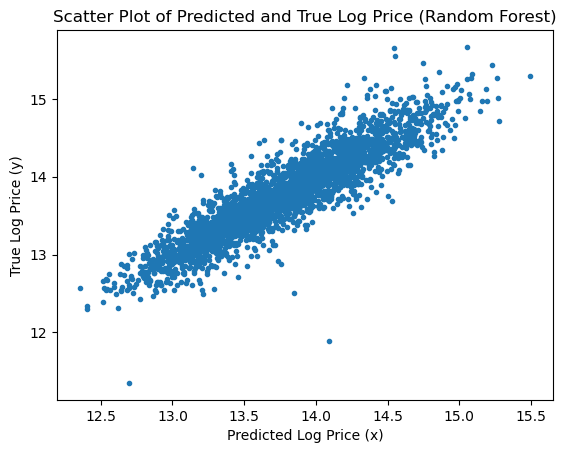

In [27]:
plt.plot(predict_price_rf, y_test_rf, '.')
plt.xlabel("Predicted Log Price (x)")
plt.ylabel("True Log Price (y)")
plt.title("Scatter Plot of Predicted and True Log Price (Random Forest)")
a = pd.DataFrame(predict_price_rf, y_test_rf).reset_index()
a = a.rename(columns={"Log_Price": "True_Value", 0: "Predicted_Value"})
a.corr()

Similarly, I plot the predicted log price and the true log price, I can see that the linear relationship here is very strong.

#### 3.3 KNN Regression

For KNN regression, based on my EDA, I decided to use similar predictors as my linear regression. But for the variable "Distance", as it is used to measure the distance between the house and the center of the city, it should have similar effect as the "Longitude" and "Latitude". Hence, I would like to try two different sets of predictors: one with Distance and the other with "Longitude" and "Latitude".

Meanwhile, as the KNN regression requires the argument of K - the number of nearest points, I would choose the K based on the RMSE of the prediction on the testing set. 

#### 3.3.1 Choice 1

In [28]:
x_knn_train1 = x_train
y_knn_train1 = y_train
x_knn_test1 = x_test
y_knn_test1 = y_test

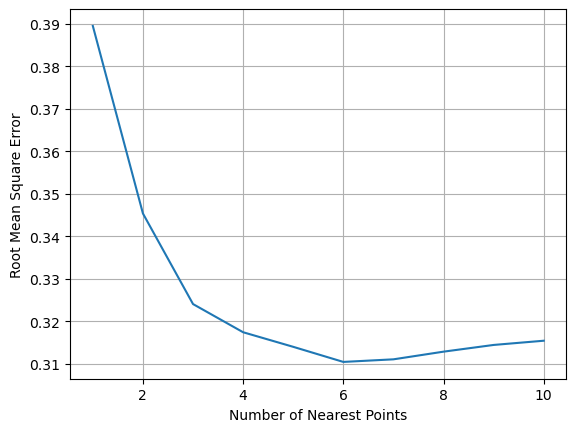

In [29]:
k = np.arange(1,11)
rmse = np.zeros(10)
for i in range(len(k)):
    knn =  KNeighborsRegressor(n_neighbors = k[i])
    knn.fit(x_knn_train1, y_knn_train1)
    rmse[i] = np.sqrt(mean_squared_error(knn.predict(x_knn_test1), y_knn_test1))
plt.plot(k,rmse)
plt.xlabel("Number of Nearest Points")
plt.ylabel("Root Mean Square Error")
plt.grid(True)
plt.show()

Based on this plot, it is clear that the K value that would give the lowest RMSE would be 6. Hence, I would choose k = 6 for the model.

In [30]:
knn =  KNeighborsRegressor(n_neighbors = 6)
knn.fit(x_knn_train1, y_knn_train1)
knn_predict_1 = knn.predict(x_knn_test1)
np.sqrt(mean_squared_error(knn_predict_1, y_knn_test1))

0.3103919075015576

#### 3.3.2 Choice 2

In [31]:
x_knn_train2 = train[['Rooms', 'Distance', 'Bathroom', 'Latitude', 'Longitude', 'h', 'u']]
y_knn_train2 = train["Log_Price"]
x_knn_test2 = test[['Rooms', 'Distance', 'Bathroom', 'Latitude', 'Longitude', 'h', 'u']]
y_knn_test2 = test["Log_Price"]

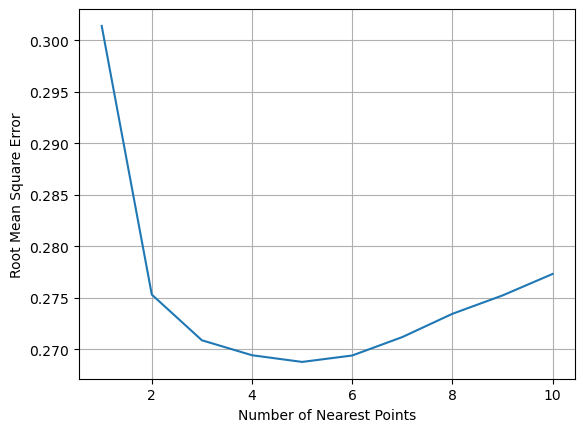

In [32]:
k = np.arange(1,11)
rmse = np.zeros(10)
for i in range(len(k)):
    knn =  KNeighborsRegressor(n_neighbors = k[i])
    knn.fit(x_knn_train2, y_knn_train2)
    rmse[i] = np.sqrt(mean_squared_error(knn.predict(x_knn_test2), y_knn_test2))
plt.plot(k,rmse)
plt.xlabel("Number of Nearest Points")
plt.ylabel("Root Mean Square Error")
plt.grid(True)
plt.show()

Similarly, for this one, I would choose k to be 5.

In [33]:
knn2 =  KNeighborsRegressor(n_neighbors = 6)
knn2.fit(x_knn_train2, y_knn_train2)
knn_predict_2 = knn2.predict(x_knn_test2)
rmse_knn = np.sqrt(mean_squared_error(knn_predict_2, y_knn_test2))
rmse_knn

0.2693900735272168

Here, we get the RMSE for two different sets of predictors. Comparison would be done in the following section.

#### 3.3.3 Comparison

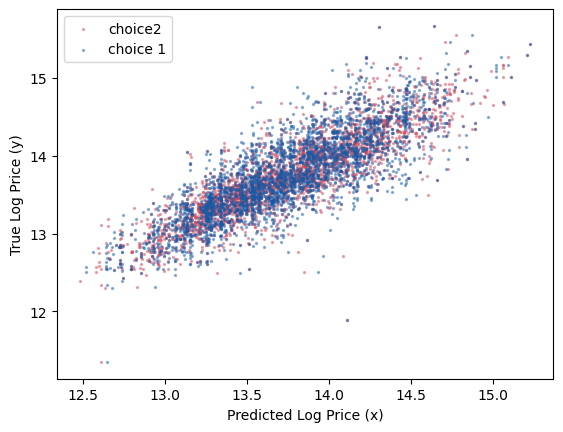

In [34]:
plt.scatter(knn_predict_2,y_knn_test2, c= '#cb495c', alpha=0.4, s=2)
plt.scatter(knn_predict_1,y_knn_test1, c= '#165aa7', alpha=0.4, s=2)
plt.legend(["choice2", "choice 1"])
plt.xlabel("Predicted Log Price (x)")
plt.ylabel("True Log Price (y)")
plt.show()

By looking at the Root Mean Square Error, we can see that our second model did a better job than our first model in the sense that it provides a smaller RMSE. However, the scatter plot here visulized that there is no clear clue for showing the model 2 is better than model 1 since they provides similar prediction for individual point. But since the RMSE is smaller, I would still choose the model 2 as my model for KNN regression.

### 4. Comparison and Results

Now, after getting three different models, I would compare them here.

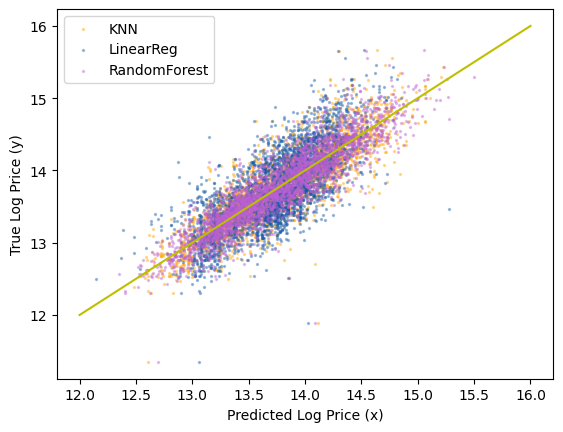

In [35]:
plt.scatter(knn_predict_2,y_knn_test2, c= '#FFA500', alpha=0.35, s=2)
plt.scatter(predict_price_lm,y_knn_test2, c= '#165aa7', alpha=0.35, s=2)
plt.scatter(predict_price_rf,y_knn_test2, c= '#bb60d5', alpha=0.35, s=2)
plt.plot([12, 16], [12,16], 'y')
plt.legend(["KNN", "LinearReg", "RandomForest"])
plt.xlabel("Predicted Log Price (x)")
plt.ylabel("True Log Price (y)")
plt.show()

In [36]:
pd.DataFrame({"Linear Regression": rmse_lm, "Random Forest": rmse_rf, "KNN Regression": rmse_knn}, ["RMSE"])

Linear Regression  Random Forest  KNN Regression
RMSE            0.35756        0.22296         0.26939

The RMSE shows that the random forest does the best job with RMSE of 0.22 and the linear regression does the worst job among these three. The scatter plot above it also support this idea. We can see that the purple dots are more squeezed around the line y = x (The line that we predict every point exactly). While for the "KNN Regression" and "Linear Regression", we can see that the KNN did slightly better. Hence, based on these arguments, I choose the random forest model with predictors: "Rooms", "Car", "Bathroom", "Distance", "YearBuilt", "Latitude", "Longitude" and "Type" to be the final model to do the house price prediction in Melboune city; and this model ends up providing a Root Mean Square Error of 0.221766 for predicting the Log House Price of the testing data.

### 5. Discussion

Although our final model seems to do a good job, there are some places that could be improved:

1. In data cleaning, I choose to delete all the rows with missing values. This step might be dangerous if the data is not missing completely at random (MCAR), i.e. the missing data's house price is depends on other helper variables or the price itself. Then, those missing values would make our remaining data not representative for the whole population, i.e. all the houses in Melboune city. Hence, a more complete dataset may help in doing the prediction.

2. There might be some other variables that are not in this dataset would be helpful to perform the prediction.

3. The number of data for house with type "h" are much larger than the other two. If we have more data for the other two types, the prediction might work better.

### 6. References


Pino, T. (2018, October 15). Melbourne Housing Market. Kaggle. https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv



Zhou, N. (2019, January 2). Australian house prices falling at fastest rate in a decade. The Guardian. What Is the Housing Bubble? https://www.theguardian.com/australia-news/2019/jan/02/australian-house-prices-falling-at-fastest-rate-in-a-decade-data-shows
